In [1]:

import tensorflow as tf
tf.enable_eager_execution()

tfe = tf.contrib.eager
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

G:\ph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
G:\ph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
G:\ph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
G:\ph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#导测试数据
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
#==划分特征和标签、建模预测==
#==用单变量预测一个未来时间点==
#取出只含温度的数据集
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E94483C9B0>],
      dtype=object)

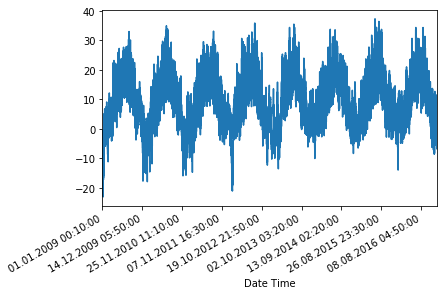

In [4]:
#温度随时间变化绘图
uni_data.plot(subplots=True)

In [5]:
#将数据集转换为数组类型
uni_data = uni_data.values
uni_data.shape

(420551,)

In [6]:
#标准化
TRAIN_SPLIT = 300000  # 只取前300000行数据 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [7]:
#划分特征和标签函数
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [8]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [9]:
print(uni_data[:25])
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

[-1.99766294 -2.04281897 -2.05439744 -2.0312405  -2.02660912 -2.00113649
 -1.95134907 -1.95134907 -1.98492663 -2.04513467 -2.08334362 -2.09723778
 -2.09376424 -2.09144854 -2.07176515 -2.07176515 -2.07639653 -2.08913285
 -2.09260639 -2.10418486 -2.10418486 -2.09492208 -2.10997409 -2.11692118
 -2.13776242]
Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [10]:
#绘图函数
def create_time_steps(length):
    return list(range(-length, 0))
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])  # 返回-20到-1的列表
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'G:\\ph\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

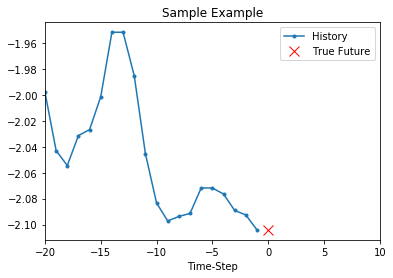

In [11]:
# 绘制第一个样本的特征和标签
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [12]:
#将特征和标签切片
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [14]:
#查看
for x, y in val_univariate.take(1):
    print(x.shape)
    print(y.shape)
#每个样本的尺寸
# (256, 20, 1)
# (256,)

(256, 20, 1)
(256,)


In [15]:
#==建模==
#用LSTM
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [16]:
#训练模型
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
Instructions for updating:
Use tf.cast instead.
200/200 [==============================] - 4s 20ms/step - loss: 0.4771 - val_loss: 0.1099
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1148 - val_loss: 0.0368
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0461 - val_loss: 0.0255
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0392 - val_loss: 0.0243
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0281 - val_loss: 0.0222
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0297 - val_loss: 0.0227
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0276 - val_loss: 0.0208
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0263 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0254 - val_loss: 0.0186
Epoch 10/10
200/200 [======================

In [ ]:
#将预测值绘制在图上
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()
#报错，Python int too large to convert to C long
#上面函数需改为Pyhton的。

In [20]:
#==用多变量预测一个未来时间点==
#取出含所考虑变量的数据集
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9482A34E0>,
      dtype=object)

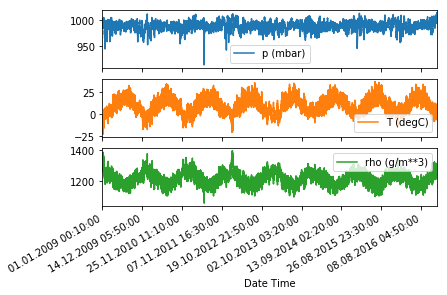

In [21]:
#绘压强、温度、密度随时间变化图
features.plot(subplots=True)

In [22]:
#将数据集转换为数组类型并标准化
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [23]:
#划分特征和标签函数
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [24]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [25]:
#查看单个样本的特征尺寸
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 3)


In [31]:
#划分数据集：训练集验证集
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<DatasetV1Adapter shapes: ((?, 120, 3), (?,)), types: (tf.float64, tf.float64)>
<DatasetV1Adapter shapes: ((?, 120, 3), (?,)), types: (tf.float64, tf.float64)>


In [32]:
#==建模==
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [33]:
#训练
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 43s 216ms/step - loss: 0.3133 - val_loss: 0.2507
Epoch 2/10
200/200 [==============================] - 68s 342ms/step - loss: 0.2648 - val_loss: 0.2503
Epoch 3/10
200/200 [==============================] - 94s 471ms/step - loss: 0.2604 - val_loss: 0.2384
Epoch 4/10
200/200 [==============================] - 124s 618ms/step - loss: 0.2581 - val_loss: 0.2379
Epoch 5/10
200/200 [==============================] - 157s 785ms/step - loss: 0.2264 - val_loss: 0.2302
Epoch 6/10
200/200 [==============================] - 181s 903ms/step - loss: 0.2389 - val_loss: 0.2573
Epoch 7/10
200/200 [==============================] - 180s 901ms/step - loss: 0.2429 - val_loss: 0.2466
Epoch 8/10
200/200 [==============================] - 167s 836ms/step - loss: 0.2420 - val_loss: 0.2475
Epoch 9/10
200/200 [==============================] - 172s 859ms/step - loss: 0.2424 - val_loss: 0.2447
Epoch 10/10
200/200 [==============================] - 172s 861ms/s

In [34]:
#==用多变量预测多个未来时间点==
#划分数据集
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [35]:
# 将特征和标签切片
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [36]:
# 绘图函数
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

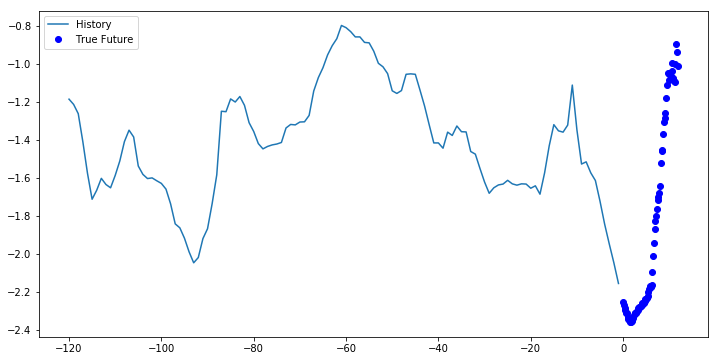

In [37]:
# 绘制温度信息（不含预测值）
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [38]:
#==建模==
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [39]:
#训练
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 94s 472ms/step - loss: 993.7692 - val_loss: 0.3477
Epoch 2/10
200/200 [==============================] - 129s 647ms/step - loss: 0.4381 - val_loss: 0.2884
Epoch 3/10
200/200 [==============================] - 147s 736ms/step - loss: 763976791121.2188 - val_loss: 33737330391.4856
Epoch 4/10
200/200 [==============================] - 174s 870ms/step - loss: 303405625.0820 - val_loss: 0.3944
Epoch 5/10
200/200 [==============================] - 202s 1s/step - loss: 0.3435 - val_loss: 0.2833
Epoch 6/10
200/200 [==============================] - 220s 1s/step - loss: 0.4850 - val_loss: 0.3375
Epoch 7/10
200/200 [==============================] - 249s 1s/step - loss: 3429050.9675 - val_loss: 188.8693
Epoch 8/10
200/200 [==============================] - 240s 1s/step - loss: 90.4169 - val_loss: 3227.7727
Epoch 9/10
200/200 [==============================] - 240s 1s/step - loss: 178.5815 - val_loss: 0.3274
Epoch 10/10
200/200 [==============

In [ ]:
# 绘制温度信息（含预测值）
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
#==【==》》函数报错，待调 Python int too large to convert to C long】

In [ ]:
#参考：https://blog.csdn.net/qq_36758914/article/details/104750077?utm_medium=distribute.pc_relevant.none-task-blog-baidujs_title-3&spm=1001.2101.3001.4242
#更多参考：https://blog.csdn.net/ssjdoudou/article/details/102469901
#【==》》待调阿里参赛数据，上传docker】